DC, for the Employment data analysis Please do the Data preparatin as following:

Get the following fields from the CICdata

  customer_id, TIN, run_date, occupationdesc, occupationstatusdesc, TradeName, employment_duration_in_days (DateHiredTo or run_date - DateHiredFrom), PSICdesc, AnnualMonthlyIndicator, Currency, GrossIncome, max_sanctioned_amt_24m, max_creditcard_limit_24m, max_financed_amt_24m, tot_granted_contracts_cnt_24m, tot_granted_contracts_amt_12m, max_sanctioned_amt_12m, Max_CreditCard_limit_12m, max_financed_amt_12m, tot_granted_contracts_cnt_12m, tot_granted_contracts_amt_12m
  
  Get the self declared employment details, application_date,  and MaxSalary information from our internal Salary scaling table using the CustomerID or TIN and application_date = run_date
  
  Get the gender, age, region, province of the customer from demographic table using customer_id or TIN and application_date = run_date
  
  Get the following fields from the Credolab tables using the customer_id or mobile number and application_date = run date:
  Device Price
  Device Manufacturer (Apple/ Samsung/ Oppo etc.)
  Device Model
  Device Age (usually derived by the application_date - earliest apps installation date)
  number of job search apps installed (linkedin, jobstreet, glint etc.)
  number of professional apps installed (office, gdrive etc)
  number of ecommerce apps installed (lazada, shopee, shein, zalora, temu etc.)
  number of ride hailing apps installed (grab, moveit etc.)
  number of finance apps installed (Banking apps, FinTech apps, eWallet apps)
  number of Risky apps (gambling apps, crypto apps, payday loan apps)
  number of OTT apps (Netflix, PrimeVideo etc.)
  Sowndarya: may be you can share your earlier apps categorisation work with DC for this. To keep things simple, just give him your final app categorisation mapping.

DC, next steps on the Income data:<br>
Tradename column from CICdata is missing, pls add it<br>
Calculate the employment duration (if no end date then run date - start date, otherwise end date - start date, if no start date then null)<br>
Create two additional flags from CICdata:<br>
--> Has Credit Loan (credit_loan_flag)<br>
--> Has Installment loan flag (inst_loan_flag)<br>
Add the other Credolab fields:<br>
--> App category wise count (just use Credolab app categories)<br>
-->  Device Brand (from credolab_raw.android_credolab_datasets_struct_columns` select Hardware.device_brand)<br>
--> Device Model (from credolab_raw.android_credolab_datasets_struct_columns` select Hardware.device_model)<br>
--> Network Provider (from credolab_raw.android_credolab_datasets_struct_columns` select GeneralData.sim_operator_name)<br>
--> Number of BlueTooth Device (from credolab_raw.android_credolab_datasets_struct_columns` select Hardware.bluetooth__bonded_devices_count)<br>

# <div align="center" style="color: #ff5733;">Income Estimation Data Preparation</div>

# Declare Libraries

In [1]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.

# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')

# %% [markdown]
## Configure Settings
# Set options or configurations as needed
# Example: pd.set_option('display.max_columns', None)

import time

# Demographic Data

In [2]:
%%time

# getting the customer demographic information from loan master table and employment information from cic employment data table

sq ="""with base as
(
-- Query for dfgranted
SELECT
  digitalLoanAccountId,
  crifApplicationId,
  customerId,
  processEngineGuid,
  requestGuid,
  ContractHistoryType,
  CBContractCode,
  ContractEndDate,
  ContractPhase,
  ContractPhaseDesc,
  ContractStartDate,
  ContractStatus,
  ContractStatusDesc,
  ContractType,
  ContractTypeDesc,
  Currency,
  CurrencyDesc,
  LastUpdateDate,
  OriginalCurrency,
  OriginalCurrencyDesc,
  ProviderCodeEncrypted,
  ProviderContractNo,
  ReferenceNo,
  Role,
  RoleDesc,
  BilledAmount,
  BoardResolutionFlag,
  BoardResolutionFlagDesc,
  CancellationDate,
  CardReferenceCode,
  ChargedAmount,
  CreditLimit,
  CreditPurpose,
  CreditPurposeDesc,
  FinancedAmount,
  FirstPaymentDate,
  FlagCardUsed,
  HolderLiability,
  HolderLiabilityDesc,
  InstallmentType,
  InstallmentTypeDesc,
  InstallmentsNumber,
  LastChargeDate,
  LastPaymentAmount,
  LastPaymentDate,
  MinPaymentIndicator,
  MinPaymentIndicatorDesc,
  MinPaymentPercentage,
  MonthlyPaymentAmount,
  NextPayment,
  NextPaymentDate,
  OutstandingBalance,
  OutstandingBalanceUnbilled,
  OutstandingPaymentsNumber,
  OverallCreditLimit,
  OverdueDays,
  OverdueDaysDesc,
  OverduePaymentsAmount,
  OverduePaymentsNumber,
  PaymentMethod,
  PaymentMethodDesc,
  PaymentPeriodicity,
  PaymentPeriodicityDesc,
  PremiumCard,
  PremiumCardDesc,
  ReorganizedCreditCode,
  ReorganizedCreditCodeDesc,
  ServicesLinesNo,
  TimesCardUsed,
  TransactionType,
  TransactionTypeDesc,
  Utilization,
  LinkedSubject_CBSubjectCode,
  LinkedSubject_Name,
  LinkedSubject_Role,
  LinkedSubject_RoleDesc,
  Note_TypeDesc,
  Note_Text,
  Note_Type,
  run_date,
  NULL AS ContractRequestDate,
  'granted' AS source
FROM
  prj-prod-dataplatform.risk_credit_cic_data.granted_contracts

UNION ALL

-- Query for dfnongranted
SELECT
  digitalLoanAccountId,
  crifApplicationId,
  customerId,
  processEngineGuid,
  requestGuid,
  NULL AS ContractHistoryType,
  CBContractCode,
  NULL AS ContractEndDate,
  ContractPhase,
  ContractPhaseDesc,
  NULL AS ContractStartDate,
  NULL AS ContractStatus,
  NULL AS ContractStatusDesc,
  ContractType,
  ContractTypeDesc,
  NULL AS Currency,
  NULL AS CurrencyDesc,
  LastUpdateDate,
  NULL AS OriginalCurrency,
  NULL AS OriginalCurrencyDesc,
  ProviderCodeEncrypted,
  ProviderContractNo,
  ReferenceNo,
  Role,
  RoleDesc,
  NULL AS BilledAmount,
  NULL AS BoardResolutionFlag,
  NULL AS BoardResolutionFlagDesc,
  NULL AS CancellationDate,
  NULL AS CardReferenceCode,
  NULL AS ChargedAmount,
  CreditLimit,
  NULL AS CreditPurpose,
  NULL AS CreditPurposeDesc,
  FinancedAmount,
  NULL AS FirstPaymentDate,
  NULL AS FlagCardUsed,
  NULL AS HolderLiability,
  NULL AS HolderLiabilityDesc,
  NULL AS InstallmentType,
  NULL AS InstallmentTypeDesc,
  InstallmentsNumber,
  NULL AS LastChargeDate,
  NULL AS LastPaymentAmount,
  NULL AS LastPaymentDate,
  NULL AS MinPaymentIndicator,
  NULL AS MinPaymentIndicatorDesc,
  NULL AS MinPaymentPercentage,
  MonthlyPaymentAmount,
  NULL AS NextPayment,
  NULL AS NextPaymentDate,
  NULL AS OutstandingBalance,
  NULL AS OutstandingBalanceUnbilled,
  NULL AS OutstandingPaymentsNumber,
  NULL AS OverallCreditLimit,
  NULL AS OverdueDays,
  NULL AS OverdueDaysDesc,
  NULL AS OverduePaymentsAmount,
  NULL AS OverduePaymentsNumber,
  NULL AS PaymentMethod,
  NULL AS PaymentMethodDesc,
  PaymentPeriodicity,
  PaymentPeriodicityDesc,
  NULL AS PremiumCard,
  NULL AS PremiumCardDesc,
  NULL AS ReorganizedCreditCode,
  NULL AS ReorganizedCreditCodeDesc,
  NULL AS ServicesLinesNo,
  NULL AS TimesCardUsed,
  NULL AS TransactionType,
  NULL AS TransactionTypeDesc,
  NULL AS Utilization,
  LinkedSubject_CBSubjectCode,
  LinkedSubject_Name,
  LinkedSubject_Role,
  LinkedSubject_RoleDesc,
  Note_TypeDesc,
  Note_Text,
  Note_Type,
  run_date,
  ContractRequestDate,
  'nongranted' AS source
FROM
  prj-prod-dataplatform.risk_credit_cic_data.notgranted_contracts
),
base2 as
(select distinct * from base),
loanmaster as --- data from loan master for customer demographic details
(select distinct customerId, digitalLoanAccountId, loanAccountNumber, startApplyDateTime, natureofwork,industryDescription, incomeMultiple, employmentstatus,credolabScore,city,
       barangay, province, postalCode, age, monthlyIncome,  tinNumber, gender, dateOfBirth, email, mobileNo,firstName, middleName, lastName, custLoanJourneyZipCode,
       custLoanJourneyProvince, custLoanJourneyCity,  tsa_onboarding_time,new_loan_type, dependentsCount,
       incomeperSalaryScale
 from prj-prod-dataplatform.risk_credit_mis.loan_master_table),
employmentdata as ---- data from employment table for employment related information
(SELECT distinct
  digitalLoanAccountId,
  crifApplicationId,
  customerId,
  AnnualMonthlyIndicator,
  Currency,
  DateHiredFrom,
  DateHiredTo,
  case when DateHiredFrom is null then null
       when DateHiredFrom is not null and  DateHiredTo is not null then date_diff(date(DateHiredTo), date(DateHiredFrom), month)
       when DateHiredFrom is not null and DateHiredTo is null then date_diff(date((select min(run_date) from base2 where base2.digitalLoanAccountId = digitalLoanAccountId)), date(DateHiredFrom), month)
       else null end Employment_duration, ---- Employement Duration
  GrossIncome,
  CAST(
    CASE
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'M' THEN CAST(COALESCE(GrossIncome, '0') AS NUMERIC)
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'Y' THEN ROUND(CAST(COALESCE(GrossIncome, '0') AS NUMERIC)/12, 0)
      ELSE 0
    END AS INT64
  ) AS MonthlyIncomecalculated, --- Monthly income calculated from Gross Income 
  CAST(
    CASE
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'M' THEN ROUND(CAST(COALESCE(GrossIncome, '0') AS NUMERIC)*12, 0)
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'Y' THEN CAST(COALESCE(GrossIncome, '0') AS NUMERIC)
      ELSE 0
    END AS INT64
  ) AS AnnualIncomecalculated,  --- Annual Income calculated from Gross Income
  Occupation,
  OccupationDesc,
  OccupationStatus,
  OccupationStatusDesc,
  TIN,
  PhoneNumber,
  PSIC,
  REGEXP_REPLACE(PSICDesc, r'^\d+\s*-\s*', '') AS PSICDesc ,
  TradeName,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from base2 where base2.digitalLoanAccountid = digitalLoanAccountId and ContractHistoryType like 'Installments') then 1 else 0 end installmentLoanFlag,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from base2 where base2.digitalLoanAccountid = digitalLoanAccountId and ContractHistoryType like '%CreditCards%' ) then 1 else 0 end creditLoanFlag,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from base2 where base2.digitalLoanAccountId = digitalLoanAccountId and ContractHistoryType like 'NonInstallments' ) then 1 else 0 end noninstallmentLoanFlag,
  row_number() over (partition by digitalLoanAccountId order by digitalLoanAccountId ) as rnk
FROM prj-prod-dataplatform.risk_credit_cic_data.employment_data)
select  ---joining both the above tables
lm.customerId, lm.digitalLoanAccountId, loanAccountNumber,
       startApplyDateTime, natureofwork, industryDescription,
       incomeMultiple, employmentstatus, credolabScore, city,
       barangay, province, postalCode, age, monthlyIncome,
       tinNumber, gender, dateOfBirth, email, mobileNo, firstName,
       middleName, lastName, custLoanJourneyZipCode,
       custLoanJourneyProvince, custLoanJourneyCity, tsa_onboarding_time, dependentsCount,incomeperSalaryScale,
       new_loan_type, ed.digitalLoanAccountId edprimarykey, crifApplicationId,
       AnnualMonthlyIndicator, DateHiredFrom,
       DateHiredTo,Employment_duration, GrossIncome, MonthlyIncomecalculated, AnnualIncomecalculated, Occupation, OccupationDesc,
       OccupationStatus, OccupationStatusDesc, TIN, PhoneNumber,
       PSIC, PSICDesc, TradeName , installmentLoanFlag, creditLoanFlag, noninstallmentLoanFlag
from loanmaster lm
inner join (select * from employmentdata where rnk = 1) ed on ed.digitalLoanAccountId = lm.digitalLoanAccountId"""

dfdemograph_employment = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')

Job ID a6d4d760-7ece-48cd-9578-5d0dfc9a89a9 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
CPU times: total: 31.9 s
Wall time: 4min 4s


In [3]:
pd.set_option("Display.max_columns", None)
dfdemograph_employment.head()

,customerId,digitalLoanAccountId,loanAccountNumber,startApplyDateTime,natureofwork,industryDescription,incomeMultiple,employmentstatus,credolabScore,city,barangay,province,postalCode,age,monthlyIncome,tinNumber,gender,dateOfBirth,email,mobileNo,firstName,middleName,lastName,custLoanJourneyZipCode,custLoanJourneyProvince,custLoanJourneyCity,tsa_onboarding_time,dependentsCount,incomeperSalaryScale,new_loan_type,edprimarykey,crifApplicationId,AnnualMonthlyIndicator,DateHiredFrom,DateHiredTo,Employment_duration,GrossIncome,MonthlyIncomecalculated,AnnualIncomecalculated,Occupation,OccupationDesc,OccupationStatus,OccupationStatusDesc,TIN,PhoneNumber,PSIC,PSICDesc,TradeName,installmentLoanFlag,creditLoanFlag,noninstallmentLoanFlag
0,2682979,37e7e82f-8da0-4014-a006-7553989b5153,None,2024-07-23 08:16:15,None,Services,NaN,SELF EMPLOYED,None,CEBU CITY,LABANGON,Cebu,6000,29,15000,None,F,30 Mar 1995,karrenardon@gmail.com,639913598840,KARREN,VILLAMOR,ARDON,6000,CEBU,CEBU CITY,2024-07-23 08:13:50,No dependents,20115.00,Quick,37e7e82f-8da0-4014-a006-7553989b5153,taran-2682979-5676785,None,None,None,<NA>,None,0,0,None,None,None,None,None,None,None,None,ALFA BUSINESS OUTSOURCING PHIL,1,1,0
1,2411518,84d3b862-66fe-4df8-8337-f2b415e85369,None,2024-06-19 23:48:47,Store/Service Manager,Services,NaN,SALARIED,451.0,CABUYAO,MARINIG,Laguna,4025,26,20000,471225742,F,02 Nov 1997,delostrinosrossellebea@gmail.com,639091474588,ROSSELLE BEA,LIOC,DELOS TRINOS,4025,LAGUNA,CABUYAO,2024-02-25 21:39:20,1,21434.00,Quick,84d3b862-66fe-4df8-8337-f2b415e85369,taran-2411518-8696117,None,None,None,<NA>,None,0,0,None,None,None,None,None,None,None,None,None,1,0,0
2,2623865,43aa6665-6817-49a2-8a3e-019424f3c25f,None,2024-07-01 02:33:43,Cashier/Food Server/Waiter,Services,NaN,SALARIED,404.0,ANGONO,SAN VICENTE,Rizal,1930,25,20000,337284312,F,31 May 1999,Antoneytaltamirano@gmail.com,639932695788,ANTONETTE MAE,ALTAMIRANO,PEREZ,1930,RIZAL,ANGONO,2024-07-01 02:27:57,3,15842.00,Quick,43aa6665-6817-49a2-8a3e-019424f3c25f,taran-2623865-9399125,None,None,None,<NA>,None,0,0,None,None,None,None,None,None,None,None,None,1,0,1
3,2741923,56656638-dddb-4957-94e1-4eb0f3337af9,None,2024-08-11 08:00:36,AIR FORCE,Services,NaN,BUSINESS OWNER/SOLE PROPRIETOR,430.0,LIPA CITY,MABINI,Batangas,4217,49,30000,None,F,23 Jun 1975,josefinavillaflor0623@gmail.com,639916955456,JOSEFINA,GRABAN,VILLAFLOR,4217,BATANGAS,LIPA CITY,2024-08-11 07:57:53,3,25170.00,Quick,56656638-dddb-4957-94e1-4eb0f3337af9,taran-2741923-7926124,None,None,None,<NA>,None,0,0,None,None,None,None,None,None,None,None,None,1,0,0
4,2562981,3485fd78-d019-4916-97aa-b426443d1aa8,None,2024-06-09 10:53:00,Call Center Agent/Tele Marketer,Services,NaN,SALARIED,500,LAPU LAPU CITY,GUN OB,Cebu,6015,46,19000,288527815,F,01 Mar 1978,cafino.geraldine@gmail.com,639978655248,GERALDINE,GARCIA,CAFINO,6015,CEBU,LAPU-LAPU CITY,2024-06-09 10:33:32,2,28872.00,Quick,3485fd78-d019-4916-97aa-b426443d1aa8,tonik-tul-549007,None,None,None,<NA>,None,0,0,None,None,None,None,None,None,None,None,None,1,0,1


In [41]:
sq = """with base as
(
-- Query for dfgranted
SELECT
  digitalLoanAccountId,
  crifApplicationId,
  customerId,
  processEngineGuid,
  requestGuid,
  ContractHistoryType,
  CBContractCode,
  ContractEndDate,
  ContractPhase,
  ContractPhaseDesc,
  ContractStartDate,
  ContractStatus,
  ContractStatusDesc,
  ContractType,
  ContractTypeDesc,
  Currency,
  CurrencyDesc,
  LastUpdateDate,
  OriginalCurrency,
  OriginalCurrencyDesc,
  ProviderCodeEncrypted,
  ProviderContractNo,
  ReferenceNo,
  Role,
  RoleDesc,
  BilledAmount,
  BoardResolutionFlag,
  BoardResolutionFlagDesc,
  CancellationDate,
  CardReferenceCode,
  ChargedAmount,
  CreditLimit,
  CreditPurpose,
  CreditPurposeDesc,
  FinancedAmount,
  FirstPaymentDate,
  FlagCardUsed,
  HolderLiability,
  HolderLiabilityDesc,
  InstallmentType,
  InstallmentTypeDesc,
  InstallmentsNumber,
  LastChargeDate,
  LastPaymentAmount,
  LastPaymentDate,
  MinPaymentIndicator,
  MinPaymentIndicatorDesc,
  MinPaymentPercentage,
  MonthlyPaymentAmount,
  NextPayment,
  NextPaymentDate,
  OutstandingBalance,
  OutstandingBalanceUnbilled,
  OutstandingPaymentsNumber,
  OverallCreditLimit,
  OverdueDays,
  OverdueDaysDesc,
  OverduePaymentsAmount,
  OverduePaymentsNumber,
  PaymentMethod,
  PaymentMethodDesc,
  PaymentPeriodicity,
  PaymentPeriodicityDesc,
  PremiumCard,
  PremiumCardDesc,
  ReorganizedCreditCode,
  ReorganizedCreditCodeDesc,
  ServicesLinesNo,
  TimesCardUsed,
  TransactionType,
  TransactionTypeDesc,
  Utilization,
  LinkedSubject_CBSubjectCode,
  LinkedSubject_Name,
  LinkedSubject_Role,
  LinkedSubject_RoleDesc,
  Note_TypeDesc,
  Note_Text,
  Note_Type,
  run_date,
  NULL AS ContractRequestDate,
  'granted' AS source
FROM
  prj-prod-dataplatform.risk_credit_cic_data.granted_contracts

UNION ALL

-- Query for dfnongranted
SELECT
  digitalLoanAccountId,
  crifApplicationId,
  customerId,
  processEngineGuid,
  requestGuid,
  NULL AS ContractHistoryType,
  CBContractCode,
  NULL AS ContractEndDate,
  ContractPhase,
  ContractPhaseDesc,
  NULL AS ContractStartDate,
  NULL AS ContractStatus,
  NULL AS ContractStatusDesc,
  ContractType,
  ContractTypeDesc,
  NULL AS Currency,
  NULL AS CurrencyDesc,
  LastUpdateDate,
  NULL AS OriginalCurrency,
  NULL AS OriginalCurrencyDesc,
  ProviderCodeEncrypted,
  ProviderContractNo,
  ReferenceNo,
  Role,
  RoleDesc,
  NULL AS BilledAmount,
  NULL AS BoardResolutionFlag,
  NULL AS BoardResolutionFlagDesc,
  NULL AS CancellationDate,
  NULL AS CardReferenceCode,
  NULL AS ChargedAmount,
  CreditLimit,
  NULL AS CreditPurpose,
  NULL AS CreditPurposeDesc,
  FinancedAmount,
  NULL AS FirstPaymentDate,
  NULL AS FlagCardUsed,
  NULL AS HolderLiability,
  NULL AS HolderLiabilityDesc,
  NULL AS InstallmentType,
  NULL AS InstallmentTypeDesc,
  InstallmentsNumber,
  NULL AS LastChargeDate,
  NULL AS LastPaymentAmount,
  NULL AS LastPaymentDate,
  NULL AS MinPaymentIndicator,
  NULL AS MinPaymentIndicatorDesc,
  NULL AS MinPaymentPercentage,
  MonthlyPaymentAmount,
  NULL AS NextPayment,
  NULL AS NextPaymentDate,
  NULL AS OutstandingBalance,
  NULL AS OutstandingBalanceUnbilled,
  NULL AS OutstandingPaymentsNumber,
  NULL AS OverallCreditLimit,
  NULL AS OverdueDays,
  NULL AS OverdueDaysDesc,
  NULL AS OverduePaymentsAmount,
  NULL AS OverduePaymentsNumber,
  NULL AS PaymentMethod,
  NULL AS PaymentMethodDesc,
  PaymentPeriodicity,
  PaymentPeriodicityDesc,
  NULL AS PremiumCard,
  NULL AS PremiumCardDesc,
  NULL AS ReorganizedCreditCode,
  NULL AS ReorganizedCreditCodeDesc,
  NULL AS ServicesLinesNo,
  NULL AS TimesCardUsed,
  NULL AS TransactionType,
  NULL AS TransactionTypeDesc,
  NULL AS Utilization,
  LinkedSubject_CBSubjectCode,
  LinkedSubject_Name,
  LinkedSubject_Role,
  LinkedSubject_RoleDesc,
  Note_TypeDesc,
  Note_Text,
  Note_Type,
  run_date,
  ContractRequestDate,
  'nongranted' AS source
FROM
  prj-prod-dataplatform.risk_credit_cic_data.notgranted_contracts
),
base2 as
(select distinct * from base),
loanmaster as --- data from loan master for customer demographic details
(select distinct customerId, digitalLoanAccountId, loanAccountNumber, startApplyDateTime, natureofwork,industryDescription, incomeMultiple, employmentstatus,credolabScore,city,
       barangay, province, postalCode, age, monthlyIncome,  tinNumber, gender, dateOfBirth, email, mobileNo,firstName, middleName, lastName, custLoanJourneyZipCode,
       custLoanJourneyProvince, custLoanJourneyCity,  tsa_onboarding_time,new_loan_type, dependentsCount,
       cast(incomeperSalaryScale as numeric) incomeperSalaryScale
 from prj-prod-dataplatform.risk_credit_mis.loan_master_table),
employmentdata as ---- data from employment table for employment related information
(SELECT distinct
  digitalLoanAccountId,
  crifApplicationId,
  customerId,
  AnnualMonthlyIndicator,
  Currency,
  DateHiredFrom,
  DateHiredTo,
  case when DateHiredFrom is null then null
       when DateHiredFrom is not null and  DateHiredTo is not null then date_diff(date(DateHiredTo), date(DateHiredFrom), month)
       when DateHiredFrom is not null and DateHiredTo is null then date_diff(date((select min(run_date) from base2 where base2.digitalLoanAccountId = digitalLoanAccountId)), date(DateHiredFrom), month)
       else null end Employment_duration,
  GrossIncome,
  CAST(
    CASE
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'M' THEN CAST(COALESCE(GrossIncome, '0') AS NUMERIC)
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'Y' THEN ROUND(CAST(COALESCE(GrossIncome, '0') AS NUMERIC)/12, 0)
      ELSE 0
    END AS INT64
  ) AS MonthlyIncomecalculated,
  CAST(
    CASE
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'M' THEN ROUND(CAST(COALESCE(GrossIncome, '0') AS NUMERIC)*12, 0)
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'Y' THEN CAST(COALESCE(GrossIncome, '0') AS NUMERIC)
      ELSE 0
    END AS INT64
  ) AS AnnualIncomecalculated,
  Occupation,
  OccupationDesc,
  OccupationStatus,
  OccupationStatusDesc,
  TIN,
  PhoneNumber,
  PSIC,
  REGEXP_REPLACE(PSICDesc, r'^\d+\s*-\s*', '') AS PSICDesc ,
  TradeName,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from base2 where base2.digitalLoanAccountid = digitalLoanAccountId and ContractHistoryType like 'Installments') then 1 else 0 end installmentLoanFlag,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from base2 where base2.digitalLoanAccountid = digitalLoanAccountId and ContractHistoryType like '%CreditCards%' ) then 1 else 0 end creditLoanFlag,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from base2 where base2.digitalLoanAccountId = digitalLoanAccountId and ContractHistoryType like 'NonInstallments' ) then 1 else 0 end noninstallmentLoanFlag,
  row_number() over (partition by digitalLoanAccountId order by digitalLoanAccountId ) as rnk
FROM prj-prod-dataplatform.risk_credit_cic_data.employment_data),
d as
(select  ---joining both the above tables
lm.customerId, lm.digitalLoanAccountId, loanAccountNumber,
       startApplyDateTime, natureofwork, industryDescription,
       incomeMultiple, employmentstatus, credolabScore, city,
       barangay, province, postalCode, age, (cast(coalesce(monthlyIncome, '0') as int64) * 12) AnnualdeclaredIncome,
       tinNumber, gender, dateOfBirth, email, mobileNo, firstName,
       middleName, lastName, custLoanJourneyZipCode,
       custLoanJourneyProvince, custLoanJourneyCity, tsa_onboarding_time , dependentsCount,
       (cast(coalesce(incomeperSalaryScale,0) as numeric)*12) as incomeperSalaryScale,
       new_loan_type, ed.digitalLoanAccountId edprimarykey, crifApplicationId,
       AnnualMonthlyIndicator, DateHiredFrom,
       DateHiredTo,Employment_duration, GrossIncome, MonthlyIncomecalculated, AnnualIncomecalculated, Occupation, OccupationDesc,
       OccupationStatus, OccupationStatusDesc, TIN, PhoneNumber,
       PSIC, PSICDesc, TradeName , installmentLoanFlag, creditLoanFlag, noninstallmentLoanFlag
from loanmaster lm
inner join (select * from employmentdata where rnk = 1) ed on ed.digitalLoanAccountId = lm.digitalLoanAccountId
)
select AnnualdeclaredIncome
, incomeperSalaryScale 
, cast(coalesce(AnnualIncomecalculated, 0) as numeric) AnnualIncomecalculated 
, customerId
from d
order by 1,2,3"""

df = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')

Job ID 0026eaba-4544-4bbe-9f5b-8187bb29df36 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282892 entries, 0 to 282891
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   AnnualdeclaredIncome    282892 non-null  Int64  
 1   incomeperSalaryScale    282892 non-null  float64
 2   AnnualIncomecalculated  282892 non-null  float64
 3   customerId              282892 non-null  Int64  
dtypes: Int64(2), float64(2)
memory usage: 9.2 MB


In [44]:
df['incomeperSalaryScale'] = pd.to_numeric(df['incomeperSalaryScale'], errors='coerce')
df['AnnualIncomecalculated'] = pd.to_numeric(df['AnnualIncomecalculated'], errors='coerce')

In [46]:
df['incomeperSalaryScale'] = df['incomeperSalaryScale'].astype(int)
df['AnnualIncomecalculated'] = df['AnnualIncomecalculated'].astype(int)

In [47]:
df.sample(10)

,AnnualdeclaredIncome,incomeperSalaryScale,AnnualIncomecalculated,customerId
206893,377388,504372,0,2368850
8671,144000,265188,0,2635309
115262,276000,263520,0,2080755
118904,287280,346464,0,2410479
221354,420000,420000,0,2303245
278926,1200000,338460,0,1974646
104587,252000,423924,0,2464104
102577,252000,252000,0,2721488
123494,288000,392964,0,2169410
31055,180000,513180,0,2459858


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282892 entries, 0 to 282891
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   AnnualdeclaredIncome    282892 non-null  Int64
 1   incomeperSalaryScale    282892 non-null  int64
 2   AnnualIncomecalculated  282892 non-null  int64
 3   customerId              282892 non-null  Int64
dtypes: Int64(2), int64(2)
memory usage: 9.2 MB


In [ ]:
# import pandas as pd
# import numpy as np

# def create_income_bins(df, columns):
#     """
#     Creates income bins for specified columns in a pandas DataFrame.
    
#     Args:
#         df: The pandas DataFrame containing the income columns.
#         columns: A string (for a single column) or a list of column names to create bins for.
    
#     Returns:
#         The DataFrame with added bin columns.
#     """
#     def get_bin_label(value):
#         if value <= 0:
#             return 'A. <=0'
#         elif 1 <= value <= 100000:
#             return f'B. {(value - 1) // 5000 * 5000 + 1}-{min((value - 1) // 5000 * 5000 + 5000, 100000)}'
#         elif 100001 <= value <= 200000:
#             return f'C. {(value - 100001) // 10000 * 10000 + 100001}-{min((value - 100001) // 10000 * 10000 + 110000, 200000)}'
#         else:
#             return 'D. >200000'

#     # Ensure columns is a list
#     if isinstance(columns, str):
#         columns = [columns]
    
#     for col in columns:
#         # Handle potential missing values
#         df[col] = pd.to_numeric(df[col], errors='coerce')
#         df[col] = df[col].fillna(0).astype(np.int64)
        
#         # Apply the binning function
#         df[f"{col}_bin"] = df[col].apply(get_bin_label)
        
#         # Create ordered categories
#         categories = ['A. <=0'] + \
#                      [f'B. {i}-{i+4999}' for i in range(1, 100001, 5000)] + \
#                      [f'C. {i}-{i+9999}' for i in range(100001, 200001, 10000)] + \
#                      ['D. >200000']
        
#         # Convert to categorical data type with specified order
#         df[f"{col}_bin"] = pd.Categorical(df[f"{col}_bin"], categories=categories, ordered=True)
    
#     return df

# # Create a dummy DataFrame
# np.random.seed(42)  # for reproducibility
# n_rows = 1000
# dummydf = pd.DataFrame({
#     'dummy_column': np.random.randint(0, 300001, size=n_rows)
# })

# # Remove duplicate values
# dummydf.drop_duplicates(subset=['dummy_column'], inplace=True)


# # Apply income binning
# dummydf = create_income_bins(dummydf, ['dummy_column'])

# # Display the first few rows
# print(dummydf.head())

# # Display value counts in the correct order
# print("\nValue counts for dummy_column bins:")
# print(dummydf['dummy_column_bin'].value_counts().sort_index())

# # Display the unique categories to verify all are present
# print("\nAll categories:")
# print(dummydf['dummy_column_bin'].cat.categories)

In [49]:
import pandas as pd
import numpy as np

def preprocess_dataframe(df):
    """
    Preprocesses the dataframe to convert scientific notation to whole numbers.
    """
    for col in ['incomeperSalaryScale', 'AnnualIncomecalculated']:
        # Convert to numeric, replacing any non-numeric values with NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Convert to integers, replacing NaN with 0
        df[col] = df[col].fillna(0).astype(int)
    return df

def create_income_bins(df, columns):
    """
    Creates income bins for specified columns in a pandas DataFrame.
    Args:
        df: The pandas DataFrame containing the income columns.
        columns: A list of column names to create bins for.
    Returns:
        The DataFrame with added bin columns.
    """
    def get_bin_label(value):
        if value <= 0:
            return 'A. <=0'
        elif 1 <= value <= 100000:
            return f'B. {(value - 1) // 5000 * 5000 + 1}-{min((value - 1) // 5000 * 5000 + 5000, 100000)}'
        elif 100001 <= value <= 200000:
            return f'C. {(value - 100001) // 10000 * 10000 + 100001}-{min((value - 100001) // 10000 * 10000 + 110000, 200000)}'
        else:
            return 'D. >200000'
    
    for col in columns:
        # Apply the binning function
        df[f"{col}_bin"] = df[col].apply(get_bin_label)
    return df

# Preprocess the dataframe
df = preprocess_dataframe(df)

# Apply income binning
df = create_income_bins(df, ['incomeperSalaryScale', 'AnnualdeclaredIncome'])

df.head()

,AnnualdeclaredIncome,incomeperSalaryScale,AnnualIncomecalculated,customerId,incomeperSalaryScale_bin,AnnualdeclaredIncome_bin
0,0,0,0,2423805,A. <=0,A. <=0
1,0,0,0,2437686,A. <=0,A. <=0
2,0,0,0,2468923,A. <=0,A. <=0
3,0,0,0,2509267,A. <=0,A. <=0
4,0,0,0,2443430,A. <=0,A. <=0


In [50]:
df[(df['AnnualdeclaredIncome'] >5000) &(df['AnnualdeclaredIncome'] <=10000)]

,AnnualdeclaredIncome,incomeperSalaryScale,AnnualIncomecalculated,customerId,incomeperSalaryScale_bin,AnnualdeclaredIncome_bin
62,5592,350604,132000,2194924,D. >200000,B. 5001-10000
63,6000,326196,278664,2570565,D. >200000,B. 5001-10000
64,6000,423924,0,2254935,D. >200000,B. 5001-10000
65,6240,241380,0,2640015,D. >200000,B. 5001-10000
66,6840,414168,0,2720728,D. >200000,B. 5001-10000
67,7200,7200,0,2590383,B. 5001-10000,B. 5001-10000
68,7200,241380,0,2624116,D. >200000,B. 5001-10000
69,8400,8400,0,2569600,B. 5001-10000,B. 5001-10000


In [51]:
df[(df['incomeperSalaryScale'] >5000) &(df['incomeperSalaryScale'] <=10000)]

,AnnualdeclaredIncome,incomeperSalaryScale,AnnualIncomecalculated,customerId,incomeperSalaryScale_bin,AnnualdeclaredIncome_bin
67,7200,7200,0,2590383,B. 5001-10000,B. 5001-10000
69,8400,8400,0,2569600,B. 5001-10000,B. 5001-10000


In [52]:
df1 = df[['customerId', 'AnnualdeclaredIncome', 'AnnualdeclaredIncome_bin']].copy()

In [53]:
df1['AnnualdeclaredIncome_bin'].value_counts(sorted)

AnnualdeclaredIncome_bin
D. >200000          0.846054
C. 170001-180000    0.061044
C. 190001-200000    0.034685
C. 110001-120000    0.013860
C. 140001-150000    0.013563
C. 160001-170000    0.010386
C. 150001-160000    0.007731
C. 180001-190000    0.003952
C. 130001-140000    0.003220
C. 120001-130000    0.001227
B. 95001-100000     0.001057
B. 55001-60000      0.000838
C. 100001-110000    0.000682
B. 70001-75000      0.000332
B. 80001-85000      0.000325
B. 35001-40000      0.000152
B. 1-5000           0.000148
B. 45001-50000      0.000110
B. 20001-25000      0.000095
B. 85001-90000      0.000095
B. 25001-30000      0.000074
A. <=0              0.000071
B. 40001-45000      0.000057
B. 15001-20000      0.000046
B. 10001-15000      0.000039
B. 50001-55000      0.000035
B. 5001-10000       0.000028
B. 75001-80000      0.000025
B. 60001-65000      0.000021
B. 65001-70000      0.000018
B. 90001-95000      0.000018
B. 30001-35000      0.000011
Name: proportion, dtype: float64

In [ ]:
# dummydf.drop(columns=['dummy_column'], inplace = True, axis = 1)


In [ ]:
# dummydf['dummy_column_bin'].value_counts(sorted, ascending=True)

In [ ]:
# dummydf = dummydf.drop_duplicates(keep='first')

In [ ]:
# dummydf.sort_values(by = 'dummy_column_bin')

In [ ]:
# dummydf[dummydf['dummy_column_bin']=='A. <=0 ']

In [ ]:
# dummydf = dummydf.merge(df1, left_on='dummy_column_bin', right_on='AnnualdeclaredIncome_bin', how = 'inner')
# dummydf.head()

In [54]:
df1 = df[['customerId', 'AnnualdeclaredIncome', 'incomeperSalaryScale','AnnualdeclaredIncome_bin',
       'incomeperSalaryScale_bin']].copy()

In [55]:
df2 = df1[['customerId', 'AnnualdeclaredIncome', 'AnnualdeclaredIncome_bin']].copy()

In [56]:
df2[df['AnnualdeclaredIncome_bin'] == 'B. 5001-10000']

,customerId,AnnualdeclaredIncome,AnnualdeclaredIncome_bin
62,2194924,5592,B. 5001-10000
63,2570565,6000,B. 5001-10000
64,2254935,6000,B. 5001-10000
65,2640015,6240,B. 5001-10000
66,2720728,6840,B. 5001-10000
67,2590383,7200,B. 5001-10000
68,2624116,7200,B. 5001-10000
69,2569600,8400,B. 5001-10000


In [57]:
# Assuming you already have df2 defined
resultdf2 = df2.groupby('AnnualdeclaredIncome_bin').agg({
    'customerId': 'nunique',
    'AnnualdeclaredIncome': 'sum'
}).reset_index()
resultdf2.sort_index()

,AnnualdeclaredIncome_bin,customerId,AnnualdeclaredIncome
0,A. <=0,20,0
1,B. 1-5000,42,21168
2,B. 10001-15000,11,140640
3,B. 15001-20000,13,235140
4,B. 20001-25000,27,638520
5,B. 25001-30000,21,610200
6,B. 30001-35000,3,97200
7,B. 35001-40000,43,1550400
8,B. 40001-45000,16,673440
9,B. 45001-50000,31,1488000


In [58]:
resultdf2[resultdf2['AnnualdeclaredIncome_bin']== 'B. 5001-10000']

,AnnualdeclaredIncome_bin,customerId,AnnualdeclaredIncome
11,B. 5001-10000,8,53472


In [59]:
resultdf2['Self_Declared_Annual_income_Avg'] = round(resultdf2['AnnualdeclaredIncome']/ resultdf2['customerId'], 3)
resultdf2.rename(columns={'customerId':'Self_Declared_user_cnt'}, inplace = True)
resultdf2

,AnnualdeclaredIncome_bin,Self_Declared_user_cnt,AnnualdeclaredIncome,Self_Declared_Annual_income_Avg
0,A. <=0,20,0,0.0
1,B. 1-5000,42,21168,504.0
2,B. 10001-15000,11,140640,12785.455
3,B. 15001-20000,13,235140,18087.692
4,B. 20001-25000,27,638520,23648.889
5,B. 25001-30000,21,610200,29057.143
6,B. 30001-35000,3,97200,32400.0
7,B. 35001-40000,43,1550400,36055.814
8,B. 40001-45000,16,673440,42090.0
9,B. 45001-50000,31,1488000,48000.0


In [60]:
df2 = df1[['customerId', 'incomeperSalaryScale', 'incomeperSalaryScale_bin']].copy()
# Assuming you already have df2 defined
resultdf3 = df2.groupby('incomeperSalaryScale_bin').agg({
    'customerId': 'nunique',
    'incomeperSalaryScale': 'sum'
}).reset_index()
resultdf3.sort_index()
resultdf3.rename(columns={'customerId':'sal_scale_user_cnt'}, inplace = True)
# Convert 'incomeperSalaryScale' to integers
resultdf3['incomeperSalaryScale'] = resultdf3['incomeperSalaryScale'].astype(int)
resultdf3['sal_scale_annual_income_avg'] = round(resultdf3['incomeperSalaryScale']/ resultdf3['sal_scale_user_cnt'], 3)
resultdf3

,incomeperSalaryScale_bin,sal_scale_user_cnt,incomeperSalaryScale,sal_scale_annual_income_avg
0,A. <=0,15853,0,0.000
1,B. 1-5000,4,2940,735.000
2,B. 10001-15000,1,12000,12000.000
3,B. 25001-30000,1,27600,27600.000
4,B. 35001-40000,4,144000,36000.000
5,B. 40001-45000,1,42000,42000.000
6,B. 45001-50000,1,48000,48000.000
7,B. 50001-55000,1,54000,54000.000
8,B. 5001-10000,2,15600,7800.000
9,B. 55001-60000,10,600000,60000.000


In [62]:
# Assuming you have already created resultdf2, resultdf3, and resultdf4

# Renaming the columns to have a common key for merging
resultdf2 = resultdf2.rename(columns={'AnnualdeclaredIncome_bin': 'income_bin'})
resultdf3 = resultdf3.rename(columns={'incomeperSalaryScale_bin': 'income_bin'})
# resultdf4 = resultdf4.rename(columns={'AnnualIncomecalculated_bin': 'income_bin'})

# Merging the dataframes
merged_df = pd.merge(resultdf2, resultdf3, on='income_bin', how='outer')
# merged_df = pd.merge(merged_df, resultdf4, on='income_bin', how='inner')

# Display the result
merged_df

,income_bin,Self_Declared_user_cnt,AnnualdeclaredIncome,Self_Declared_Annual_income_Avg,sal_scale_user_cnt,incomeperSalaryScale,sal_scale_annual_income_avg
0,A. <=0,20,0,0.0,15853.0,0.000000e+00,0.000
1,B. 1-5000,42,21168,504.0,4.0,2.940000e+03,735.000
2,B. 10001-15000,11,140640,12785.455,1.0,1.200000e+04,12000.000
3,B. 15001-20000,13,235140,18087.692,NaN,NaN,NaN
4,B. 20001-25000,27,638520,23648.889,NaN,NaN,NaN
5,B. 25001-30000,21,610200,29057.143,1.0,2.760000e+04,27600.000
6,B. 30001-35000,3,97200,32400.0,NaN,NaN,NaN
7,B. 35001-40000,43,1550400,36055.814,4.0,1.440000e+05,36000.000
8,B. 40001-45000,16,673440,42090.0,1.0,4.200000e+04,42000.000
9,B. 45001-50000,31,1488000,48000.0,1.0,4.800000e+04,48000.000


In [66]:
merged_df['sal_scale_user_cnt'] = merged_df['sal_scale_user_cnt'].fillna(0)
merged_df['incomeperSalaryScale'] = merged_df['incomeperSalaryScale'].fillna(0)
merged_df['Self_Declared_Annual_income_Avg']= merged_df['Self_Declared_Annual_income_Avg'].fillna(0)
merged_df['sal_scale_annual_income_avg']= merged_df['sal_scale_annual_income_avg'].fillna(0)
merged_df['sal_scale_user_cnt'] = merged_df['sal_scale_user_cnt'].astype(int)
merged_df['incomeperSalaryScale'] = merged_df['incomeperSalaryScale'].astype(int)
merged_df['Self_Declared_Annual_income_Avg']= merged_df['Self_Declared_Annual_income_Avg'].astype(int)
merged_df['sal_scale_annual_income_avg']= merged_df['sal_scale_annual_income_avg'].astype(int)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   income_bin                       32 non-null     object
 1   Self_Declared_user_cnt           32 non-null     int64 
 2   AnnualdeclaredIncome             32 non-null     Int64 
 3   Self_Declared_Annual_income_Avg  32 non-null     int64 
 4   sal_scale_user_cnt               32 non-null     int64 
 5   incomeperSalaryScale             32 non-null     int64 
 6   sal_scale_annual_income_avg      32 non-null     int64 
dtypes: Int64(1), int64(5), object(1)
memory usage: 1.9+ KB


In [67]:
merged_df

,income_bin,Self_Declared_user_cnt,AnnualdeclaredIncome,Self_Declared_Annual_income_Avg,sal_scale_user_cnt,incomeperSalaryScale,sal_scale_annual_income_avg
0,A. <=0,20,0,0,15853,0,0
1,B. 1-5000,42,21168,504,4,2940,735
2,B. 10001-15000,11,140640,12785,1,12000,12000
3,B. 15001-20000,13,235140,18087,0,0,0
4,B. 20001-25000,27,638520,23648,0,0,0
5,B. 25001-30000,21,610200,29057,1,27600,27600
6,B. 30001-35000,3,97200,32400,0,0,0
7,B. 35001-40000,43,1550400,36055,4,144000,36000
8,B. 40001-45000,16,673440,42090,1,42000,42000
9,B. 45001-50000,31,1488000,48000,1,48000,48000


In [68]:
mdf = merged_df[['income_bin', 'Self_Declared_Annual_income_Avg', 'sal_scale_annual_income_avg']].copy()

In [70]:
mdf = mdf.drop(mdf[
    (mdf['income_bin'] == 0) | 
    (mdf['Self_Declared_Annual_income_Avg'] == 0) | 
    (mdf['sal_scale_annual_income_avg'] == 0)
].index)
mdf

,income_bin,Self_Declared_Annual_income_Avg,sal_scale_annual_income_avg
1,B. 1-5000,504,735
2,B. 10001-15000,12785,12000
5,B. 25001-30000,29057,27600
7,B. 35001-40000,36055,36000
8,B. 40001-45000,42090,42000
9,B. 45001-50000,48000,48000
10,B. 50001-55000,53454,54000
11,B. 5001-10000,6684,7800
12,B. 55001-60000,59979,60000
15,B. 70001-75000,72051,72000


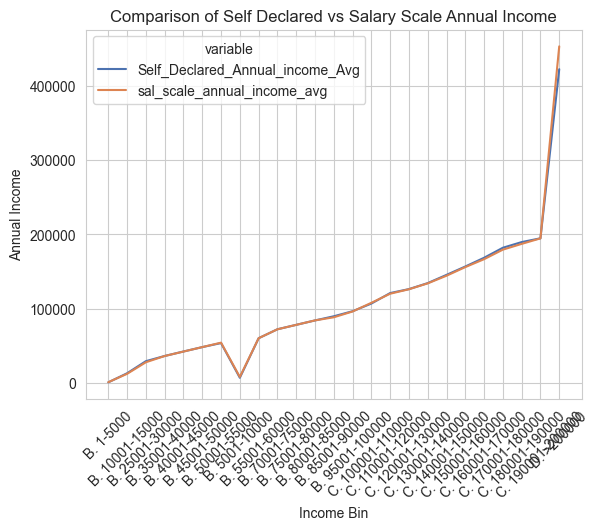

In [71]:
# Create the line plot using seaborn
sns.lineplot(x='income_bin', y='value', hue='variable', data=mdf.melt(id_vars='income_bin', var_name='variable', value_name='value'))

# Set labels and title
plt.xlabel('Income Bin')
plt.ylabel('Annual Income')
plt.title('Comparison of Self Declared vs Salary Scale Annual Income')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

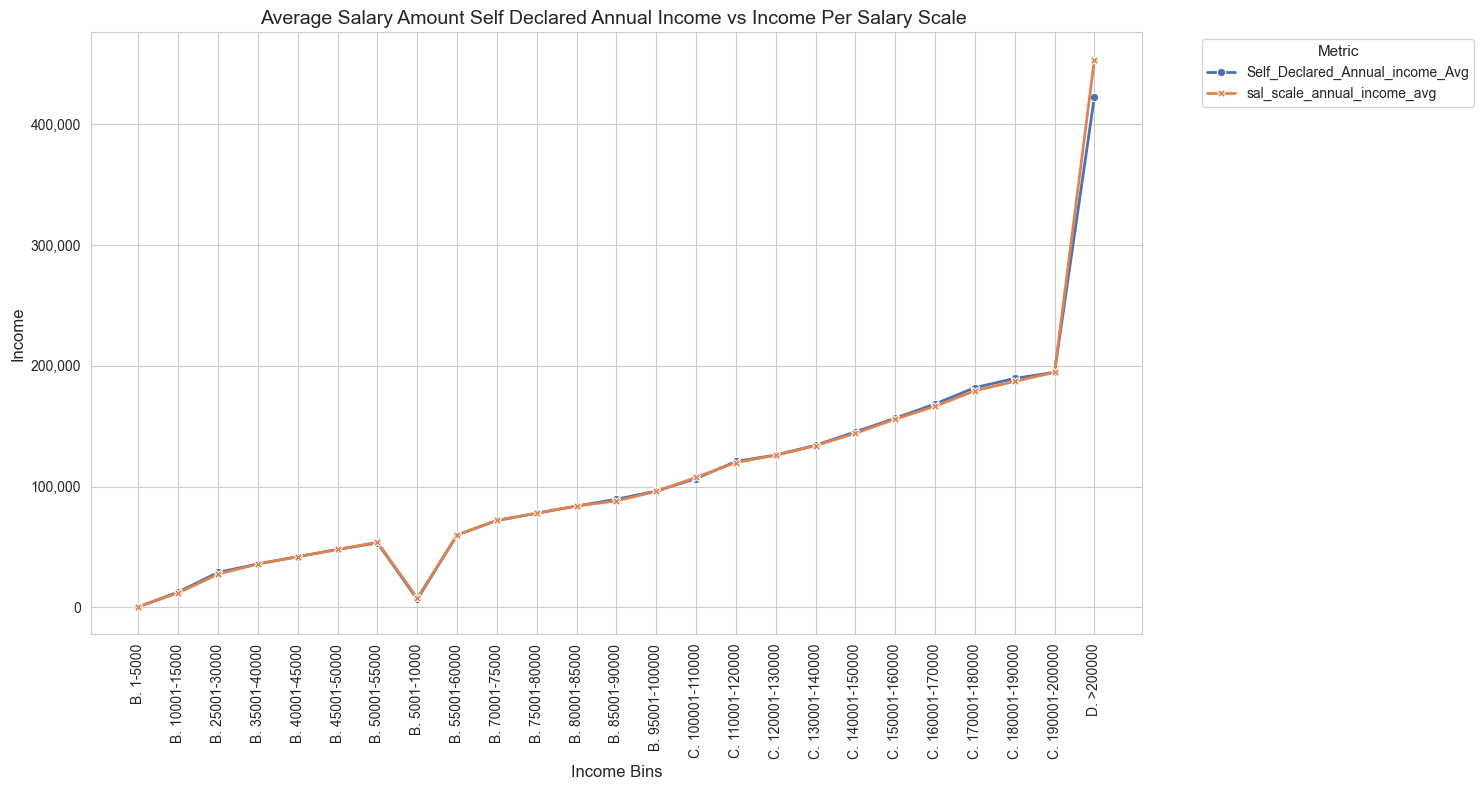

In [74]:
df_grouped = mdf.groupby('income_bin').agg({
    'Self_Declared_Annual_income_Avg': 'sum', 
    'sal_scale_annual_income_avg': 'sum', 
    })

# Set the Seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Create the line plot
sns.lineplot(data=df_grouped, markers=True, dashes=False, linewidth=2, ax=ax)

# Customize the plot
ax.set_xlabel('Income Bins', fontsize=12)
ax.set_ylabel('Income', fontsize=12)
ax.set_title('Average Salary Amount Self Declared Annual Income vs Income Per Salary Scale ', fontsize=14, wrap=True)
ax.legend(title='Metric', title_fontsize='11', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Format y-axis labels with thousand separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()

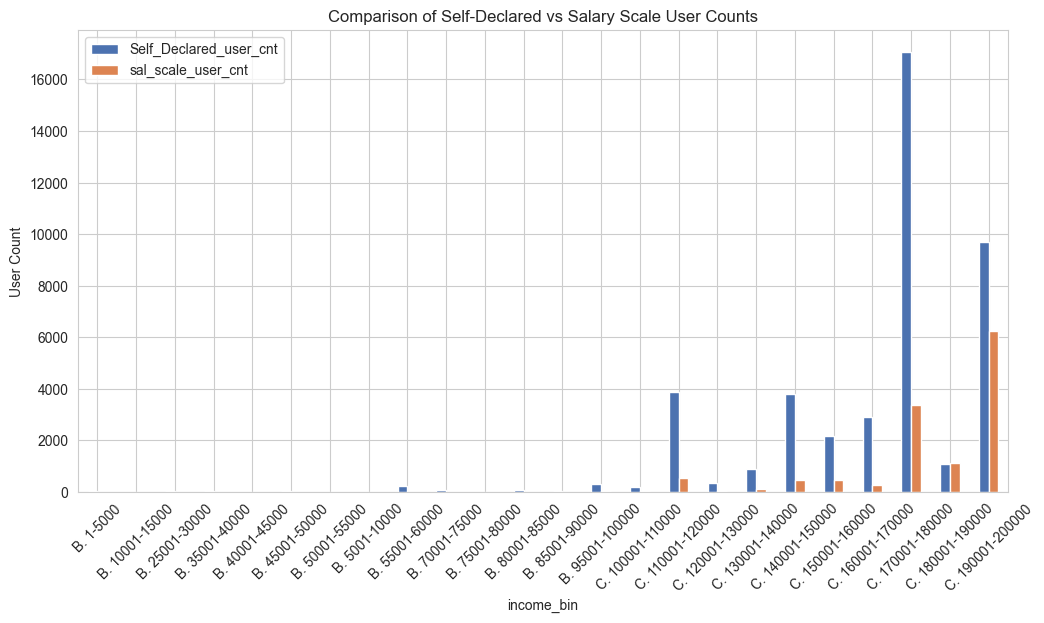

In [39]:
filtered_df[['income_bin', 'Self_Declared_user_cnt', 'sal_scale_user_cnt']].plot(x='income_bin', kind='bar', figsize=(12, 6))
plt.title('Comparison of Self-Declared vs Salary Scale User Counts')
plt.ylabel('User Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
df2 = df1[['customerId', 'AnnualIncomecalculated', 'AnnualIncomecalculated_bin']].copy()

resultdf4 = df2.groupby('AnnualIncomecalculated_bin').agg({
    'customerId': 'nunique',
    'AnnualIncomecalculated': 'sum'
}).reset_index()

resultdf4.sort_index()
resultdf4.rename(columns={'customerId':'cic_user_cnt'}, inplace=True)

# Convert 'AnnualIncomecalculated' to integers
resultdf4['AnnualIncomecalculated'] = resultdf4['AnnualIncomecalculated'].astype(int)

# Calculate average and round to 2 decimal places
resultdf4['cic_annual_income_avg'] = round(resultdf4['AnnualIncomecalculated'] / resultdf4['cic_user_cnt'], 2)

resultdf4

In [ ]:
resultdf2.head()

In [ ]:
resultdf3.head()

In [ ]:
resultdf4.head()

In [ ]:

# Assuming you have already created resultdf2, resultdf3, and resultdf4

# Renaming the columns to have a common key for merging
resultdf2 = resultdf2.rename(columns={'AnnualdeclaredIncome_bin': 'income_bin'})
resultdf3 = resultdf3.rename(columns={'incomeperSalaryScale_bin': 'income_bin'})
resultdf4 = resultdf4.rename(columns={'AnnualIncomecalculated_bin': 'income_bin'})

# Merging the dataframes
merged_df = pd.merge(resultdf2, resultdf3, on='income_bin', how='inner')
merged_df = pd.merge(merged_df, resultdf4, on='income_bin', how='inner')

# Display the result
merged_df

In [ ]:
merged_df.columns

In [ ]:
merged_df.to_csv("combinedview_check.csv", index = False)

In [ ]:
# Assuming mdf2 and df_grouped are already defined as in your code
df_grouped = merged_df.groupby('income_bin').agg({
    'Self_Declared_user_cnt': 'max', 
    'sal_scale_user_cnt': 'max', 
    'cic_user_cnt': 'max'
})

# Set the Seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Create the line plot
sns.lineplot(data=df_grouped, markers=True, dashes=False, linewidth=2, ax=ax)

# Customize the plot
ax.set_xlabel('Income Bins', fontsize=12)
ax.set_ylabel('Count Of Unique Customer', fontsize=12)
ax.set_title('Count of Unique Customer for  Self Declared Annual Income vs Income Per Salary Scale vs CIC Gross Annual Income by Income Bins', fontsize=14, wrap=True)
ax.legend(title='Metric', title_fontsize='11', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=90, ha='right')
ax.yaxis.set_ticks(range(0, 250000, 5000))

# Format y-axis labels with thousand separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Assuming mdf2 and df_grouped are already defined as in your code
df_grouped = merged_df.groupby('income_bin').agg({
    'Self_Declared_Annual_income_Avg': 'max', 
    'sal_scale_user_cnt': 'max', 
    'cic_user_cnt': 'max'
})

# Set the Seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Create the line plot
sns.lineplot(data=df_grouped, markers=True, dashes=False, linewidth=2, ax=ax)

# Customize the plot
ax.set_xlabel('Income Bins', fontsize=12)
ax.set_ylabel('Count Of Unique Customer', fontsize=12)
ax.set_title('Count of Unique Customer for Self Declared Annual Income vs Income Per Salary Scale vs CIC Gross Annual Income by Income Bins', fontsize=14, wrap=True)
ax.legend(title='Metric', title_fontsize='11', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Set y-axis limit to 100,000 and create ticks every 100
ax.set_ylim(0, 100000)
ax.yaxis.set_ticks(range(0, 60000, 2000))

# Format y-axis labels with thousand separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_grouped = merged_df.groupby('income_bin').agg({
    'Self_Declared_user_cnt': 'max', 
    'sal_scale_user_cnt': 'max', 
    'cic_user_cnt': 'max'
})

# Set the Seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Create the line plot
sns.lineplot(data=df_grouped, markers=True, dashes=False, linewidth=2, ax=ax)

# Customize the plot
ax.set_xlabel('Income Bins', fontsize=12)
ax.set_ylabel('Count Of Unique Customer', fontsize=12)
ax.set_title('Count of Unique Customer for Self Declared Annual Income vs Income Per Salary Scale vs CIC Gross Annual Income by Income Bins', fontsize=14, wrap=True)
ax.legend(title='Metric', title_fontsize='11', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Set y-axis limit to 100,000 and create ticks every 100
ax.set_ylim(0, 100000)
ax.yaxis.set_ticks(range(-2000, 20000, 1000))

# Format y-axis labels with thousand separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
dfplotcnt = df_grouped.reset_index()

In [ ]:
dfplotcnt.to_csv("dfplotcnt.csv", index = False)

In [ ]:
df_grouped = merged_df.groupby('income_bin').agg({
  'Self_Declared_user_cnt': 'max', 
  'sal_scale_user_cnt': 'max', 
  'cic_user_cnt': 'max'
})

# Set the Seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Create the line plot
sns.lineplot(data=df_grouped, markers=True, dashes=False, linewidth=2, ax=ax)

# Set log scale on y-axis using Matplotlib
ax.set_yscale('log')

# Customize the plot
ax.set_xlabel('Income Bins', fontsize=12)
ax.set_ylabel('Count Of Unique Customer (Log Scale)', fontsize=12)  # Update label with "Log Scale"
ax.set_title('Count of Unique Customer for  Self Declared Annual Income vs Income Per Salary Scale vs CIC Gross Annual Income by Income Bins', fontsize=14, wrap=True)
ax.legend(title='Metric', title_fontsize='11', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=90, ha='right')

# No need to set specific y-axis ticks with log scale

# Format y-axis labels to show actual values (optional)
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(10**x, ',')))  # This formats based on log scale

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
merged_df.columns

In [ ]:
df_grouped = merged_df.groupby('income_bin').agg({
    'Self_Declared_Annual_income_Avg': 'sum', 
    'sal_scale_annual_income_avg': 'sum', 
    'cic_annual_income_avg': 'sum'
})

dfplotavgincome= df_grouped.reset_index()
dfplotavgincome.to_csv("dfplotavgincome.csv", index = False)
dfplotavgincome

In [ ]:
df_grouped = merged_df.groupby('income_bin').agg({
  'Self_Declared_user_cnt': 'max', 
  'sal_scale_user_cnt': 'max', 
  'cic_user_cnt': 'max'
})

# Set the Seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Create the line plot with log scale on y-axis
sns.lineplot(data=df_grouped, markers=True, dashes=False, linewidth=2, ax=ax, yscale="log")

# Customize the plot
ax.set_xlabel('Income Bins', fontsize=12)
ax.set_ylabel('Count Of Unique Customer (Log Scale)', fontsize=12)  # Update label with "Log Scale"
ax.set_title('Count of Unique Customer for  Self Declared Annual Income vs Income Per Salary Scale vs CIC Gross Annual Income by Income Bins', fontsize=14, wrap=True)
ax.legend(title='Metric', title_fontsize='11', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=90, ha='right')

# No need to set specific y-axis ticks with log scale

# Format y-axis labels to show actual values (optional)
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(10**x, ',')))  # This formats based on log scale

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()
